# Fig 7H-J & Fig. S7
The IO imaging in Fig. 7 showed that the IO memory cells rectify and linearly integrate oscillatory inputs. Thus, even though IO neurons are necessary for the memory-based OMR, even after the oscillatory stimuli that effectively erase the optic flow memory, IO neurons still appear to "remember" the optic flow that happened before the oscillatory stimuli.

Here, I propose two models that connect IO activity and behavior, using different nonlinear algorithms.

In [1]:
# packages
import numpy as np
from matplotlib import  pyplot as plt
import colorcet as cc
from homr_util import *

In [2]:
# Tweaking matplotlib 
set_rcParams()

## Model definition
### Model functions

In [3]:
def sigmoid(x, b, mu):
    '''
    A utility function to calculate sigmoid.
    '''
    return 1/(1 + np.exp(b*(-x+mu)))

def drive_model(dt, s, tau, memory_saturating_velocity, w):
    '''
    Retrun internal drive to swim given stimulus as velocity.
    We rectify the stimulus by direction, and separately integrate
    positive and negative with the specified tau (= this part models IO).
    We pass the integrated value through zero-mean logistic function 
    with changeable beta (= determines how fast it sautrates).
    This saturation enables forgetting after oscillation.
    We then add this hysteretic term to the stimulus with a weight w.
    '''
    
    # prepare separate integrating units for forward and backward
    rf = np.zeros(s.shape)
    rb = np.zeros(s.shape)
    
    # rectify stimuli
    sf = +s * (s>0)
    sb = -s * (s<0)
    
    for i in range(1, s.shape[-1]):
        # rf and rb have the same scale as the input velocity
        # because their steady state when s is constant is s
        rf[..., i] = rf[..., i-1] + (-rf[..., i-1] + sf[..., i-1]) * dt / tau 
        rb[..., i] = rb[..., i-1] + (-rb[..., i-1] + sb[..., i-1]) * dt / tau 
    
    # do saturating nonlinearity and take the difference (bounded between -1 to 1)
    # The logistic function reaches 95% at x=3, and I equate the "memory_saturating_velocity"
    # to this value
    beta = 3/memory_saturating_velocity
    rfsig = 2*sigmoid(rf, beta, 0) - 1 # scaling to [0, 1]
    rbsig = 2*sigmoid(rb, beta, 0) - 1
    rdiff = rfsig - rbsig
    r = s + rdiff*w
    
    return r, rf, rb # return rf/rb for visualization


def normalizing_drive_model(dt, s, tau, w, epsilon=0.01):
    '''
    Retrun internal drive to swim given stimulus as velocity.
    We rectify the stimulus by direction, and separately integrate
    positive and negative with the specified tau (= this models IO).
    The 'drive' output is the difference of the two integrate 
    signals, divided by the sum of two. This normalization process
    allows 'forgetting' after oscillatory inputs.
    '''
    
    # prepare separate integrating units for forward and backward
    rf = np.zeros(s.shape)
    rb = np.zeros(s.shape)
    
    # rectify stimuli
    sf = +s * (s>0)
    sb = -s * (s<0)
    
    for i in range(1, s.shape[-1]):
        # rf and rb have the same scale as the input velocity
        # because their steady state when s is constant is s
        rf[..., i] = rf[..., i-1] + (-rf[..., i-1] + sf[..., i-1]) * dt / tau 
        rb[..., i] = rb[..., i-1] + (-rb[..., i-1] + sb[..., i-1]) * dt / tau 
    
    r = s + w*(rf-rb)/(rf+rb+epsilon)
    return r, rf, rb # return rf/rb for visualization



# Probabilistic bouting model
# Severi 2014 says in free swimming swimming effort saturates at 20 mm/s
# Do not implement refractory period now because I am lazy, just do uniform distribution
def boutmodel(dt, s, base_rate, max_rate, saturating_velocity = 30):
    '''
    Given stimulus (or drive in the unit of mm/s)
    Calculate bout probability with a logistic function
    Logistic function takes 50% value at x=0, and reaches ~95% at x=3
    So, given the saturating velocity Vs, we set the 50% to be Vs/2
    and 95% point to be Vs
    Thus mu = Vs/2, beta = 6/Vs
    '''

    bout_rate = base_rate + (max_rate - base_rate) * sigmoid(s, 6/saturating_velocity, saturating_velocity/2)
    bout = bout_rate*dt > np.random.rand(*s.shape)
    
    return bout, bout_rate

def fit_exponential(t, y):
    '''
    utility function for exponential fitting
    '''
    regressor = np.vstack((t, np.ones(len(t))))
    nonneg = y>0 # ignore negative points because nan breaks linalg
    alpha, beta = np.linalg.lstsq(regressor[:, nonneg].T, np.log(y[nonneg]), rcond=None)[0]
    tau = 1/alpha
    return tau, beta

### Simulation parameters

In [4]:
dt = 0.1 # simulation was run at 10 Hz
tau = 15 # tau of the IO neurons
w = 5.0 # ratio of immediate vs. memory dependent components of swim
saturating_velocity = 1.0

# bout rate
base_rate = 0.05
max_rate = 1.0
max_vel = 30 # saturating velocity in mm/s

## Simulation
### Wait with wave experiment (Fig. 5)
#### Generate stimuli

In [6]:
t_s = np.arange(0,35, dt)
speed = 5
wave_period = 2
wait_durations = np.arange(0, 12, 2)

stim_nw = []
stim_w = []
for this_wait in wait_durations:
    # first create "wave" during waiting
    
    wave = (speed * np.sin(t_s * np.pi * 2 / wave_period)) * ((t_s>8)*(t_s<8+this_wait))
    pre_pulse = (t_s>5)*(t_s<8)
    probe_pulse = (t_s>8+this_wait)*(t_s<8+this_wait+10)
    
    stim_nw.append((pre_pulse*speed + probe_pulse*speed, pre_pulse*(-speed) + probe_pulse*speed))    
    stim_w.append((pre_pulse*speed + probe_pulse*speed +wave, pre_pulse*(-speed) + probe_pulse*speed +wave))
    
stim_w = np.asarray(stim_w)
stim_nw = np.asarray(stim_nw)

#### Run models

In [7]:
rw, rwf, rwb    = drive_model(dt, stim_w, tau, saturating_velocity, w)
rnw, rnwf, rnwb = drive_model(dt, stim_nw, tau, saturating_velocity, w)

nrw, _, _ = normalizing_drive_model(dt, stim_w, tau, w)
nrnw, _, _ = normalizing_drive_model(dt, stim_nw, tau, w)

_, p_w = boutmodel(dt, rw, base_rate, max_rate)
_, p_nw = boutmodel(dt, rnw, base_rate, max_rate)
_, np_w = boutmodel(dt, nrw, base_rate, max_rate)
_, np_nw = boutmodel(dt, nrnw, base_rate, max_rate)

## Panels
### Fig. 7I (Saturation model time traces)

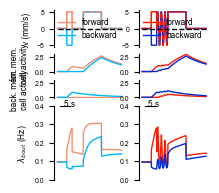

In [8]:
fig, ax = plt.subplots(4, 2, figsize=(2, 2.2), height_ratios=(2,1,1,4))

labels = ('forward', 'backward')
k = 3
for j in range(2):
    # stimuli
    ax[0,0].plot(t_s, stim_nw[k][j], color=cc.cm.CET_D11(1.0-j), label=labels[j])
    ax[0,1].plot(t_s, stim_w[k][j], color=cc.cm.CET_D8(1.0-j), label=labels[j])

    # f cell
    ax[1,0].plot(t_s, rnwf[k][j], color=cc.cm.CET_D11(1.0-j), label=labels[j])
    ax[1,1].plot(t_s, rwf[k][j], color=cc.cm.CET_D8(1.0-j), label=labels[j])

    # b cell
    ax[2,0].plot(t_s, rnwb[k][j], color=cc.cm.CET_D11(1.0-j), label=labels[j])
    ax[2,1].plot(t_s, rwb[k][j], color=cc.cm.CET_D8(1.0-j), label=labels[j])
    
    # bout rate
    ax[3,0].plot(t_s, p_nw[k][j], color=cc.cm.CET_D11(1.0-j))
    ax[3,1].plot(t_s, p_w[k][j], color=cc.cm.CET_D8(1.0-j))

ax[0,0].plot(t_s, stim_nw[k][0],  '--', color=cc.cm.CET_D11(1.0))
ax[0,1].plot(t_s, stim_w[k][0],  '--', color=cc.cm.CET_D8(1.0))

# axis management

ax[0,0].set_ylabel('v (mm/s)')
ax[1,0].set_ylabel('for. mem.\ncell activity')
ax[2,0].set_ylabel('back. mem.\ncell activity')
ax[3,0].set_ylabel('$\lambda_{bout}$ (Hz)')

for i in range(2):
    ax[0,i].plot(t_s, 0*t_s, 'k--')
    ax[0,i].legend(loc='upper right')

    ax[1,i].set_ylim(-0.2, 3)
    ax[2,i].set_ylim(-0.2, 3)
   
    ax[3,i].plot([2,7], [0.4,0.4],'k-',lw=1.5)    
    ax[3,i].text(3.5, 0.4, '5 s')
    ax[3,i].set_ylim(0, 0.4)

    for j in range(4):
        toggle_spines(ax[j,i], 0, 0, 0, 1)
        
plt.savefig('./svgs/Fig7I.svg', format='svg')
plt.show()

### Fig. 7J (saturation model bout rate difference by wait duration, w/o wave)

In [9]:
pdiff_w = []
pdiff_nw = []
for i, this_wait in enumerate(wait_durations):
    pdiff_w.append(-np.diff(np.mean(p_w[i, :, (t_s>8+this_wait)*(t_s<8+this_wait+10)], axis=0)))
    pdiff_nw.append(-np.diff(np.mean(p_nw[i, :, (t_s>8+this_wait)*(t_s<8+this_wait+10)], axis=0)))

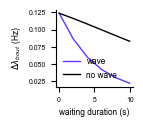

In [11]:
plt.figure(figsize=(1, 1))
plt.plot(wait_durations, pdiff_w, label='wave', color=(0.4, 0.2, 1.0))
plt.plot(wait_durations, pdiff_nw, label='no wave', color=(0,0,0))

plt.xlabel('waiting duration (s)')
plt.ylabel('$\Delta\lambda_{bout}$ (Hz)')
toggle_spines(plt.gca(), 0, 1, 0, 1)
plt.legend()
plt.savefig('./svgs/Fig7J.svg', format='svg')
plt.show()

### Fig. S7B (Normalization model time traces)
- We do not show teh rectified integrator steps because they are identical to the saturation model

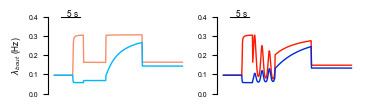

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(4, 1))

labels = ('forward', 'backward')

# bout rate
for j in range(2):
    ax[0].plot(t_s, np_nw[k][j], color=cc.cm.CET_D11(1.0-j))
    ax[1].plot(t_s, np_w[k][j], color=cc.cm.CET_D8(1.0-j))
ax[0].set_ylabel('$\lambda_{bout}$ (Hz)')

for i in range(2):
    ax[i].plot([2,7], [0.4,0.4],'k-',lw=1.5)    
    ax[i].text(3.5, 0.4, '5 s')
    ax[i].set_ylim(0, 0.4)
    toggle_spines(ax[i], 0, 0, 0, 1)

plt.savefig('./svgs/FigS7B.svg', format='svg')
plt.show()

### Fig. 7J (Normalization model bout rate difference by wait duration, w/o wave)

In [14]:
npdiff_w = []
npdiff_nw = []
for i, this_wait in enumerate(wait_durations):
    npdiff_w.append(-np.diff(np.mean(np_w[i, :, (t_s>8+this_wait)*(t_s<8+this_wait+10)], axis=0)))
    npdiff_nw.append(-np.diff(np.mean(np_nw[i, :, (t_s>8+this_wait)*(t_s<8+this_wait+10)], axis=0)))

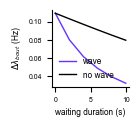

In [16]:
plt.figure(figsize=(1, 1))
plt.plot(wait_durations, npdiff_w, label='wave', color=(0.4, 0.2, 1.0))
plt.plot(wait_durations, npdiff_nw, label='no wave', color=(0,0,0))

plt.xlabel('waiting duration (s)')
plt.ylabel('$\Delta\lambda_{bout}$ (Hz)')
toggle_spines(plt.gca(), 0, 1, 0, 1)
plt.legend()

plt.savefig('./svgs/FigS7C.svg', format='svg')
plt.show()